In [27]:
import pickle
import numpy as np
import re
import matplotlib.pyplot as plt

files = {
    "ensemble": {
        "train": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T15-46-05/results_train.pkl",
        "test": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T15-46-05/results_test.pkl",
        # "test": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-11T19-10-09/results_test.pkl",
        # "train": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-11T19-10-09/results_train.pkl",
    },
    "base": {
        "train": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T22-28-43/results_train.pkl",
        "test": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T22-28-43/results_test.pkl",
    },
    "single_traj": {
        # "train": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T03-24-54/results_train.pkl",
        # "test": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T03-24-54/results_test.pkl",
        "test": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-13T14-40-24/results_test.pkl",
        "train": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-13T14-40-24/results_train.pkl",
    },
    "no_temp": {
        "train": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T03-24-56/results_train.pkl",
        "test": "/home/paperspace/Projects/posteriors/examples/bayes_llama3/experiments/TQA/2024-05-10T03-24-56/results_test.pkl"
    }
}

results = {}
for key, val in files.items():
    result = {}
    for split, file in val.items():
        with open(file, "rb") as f:
            result[split] = pickle.load(f)
    results[key] = result

In [28]:
def lcs(x, y):
    m = len(x)
    n = len(y)
    dp = np.zeros((m + 1, n + 1), dtype=int)

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if x[i - 1] == y[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    return dp[m][n]


def measure(vals):
    accuracy = 0

    correct_responses = []
    incorrect_responses = []
    for _, val in vals.items():
        val["expected_response"] = re.sub(r"[^\w\s]", "", val["expected_response"])
        val["response"] = re.sub(r"[^\w\s]", "", val["response"])
        hypothesis_words = val["response"].lower().split()
        reference_words = val["expected_response"].lower().split()

        is_correct = lcs(hypothesis_words, reference_words)
        # print(hypothesis_words, val["expected_response"], is_correct)
        if is_correct:
            accuracy += 1
            correct_responses.append(val)
        else:
            incorrect_responses.append(val)

    return {"accuracy": accuracy / len(vals), "correct": correct_responses, "incorrect": incorrect_responses}

metrics = {}
for key, val in results.items():
    metric = {}
    for split, saved_vals in val.items():
        metric[split] = measure(saved_vals)
    metrics[key] = metric

for key, val in metrics.items():
    for keyb in ["train", "test"]:
        print(key, keyb, metrics[key][keyb]["accuracy"])

ensemble train 0.7997223186393614
ensemble test 0.7687400318979266
base train 0.7991438158046974
base test 0.7699362041467305
single_traj train 0.8426560808372429
single_traj test 0.7743221690590112
no_temp train 0.8225153303251186
no_temp test 0.7870813397129187


Text(0.5, 1.0, 'Total uncertainties on MCQ')

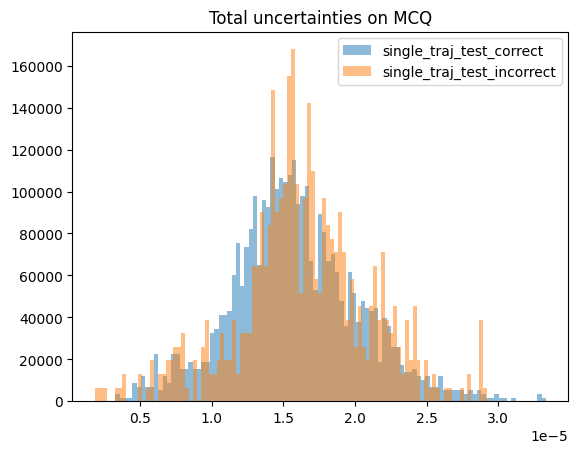

In [29]:
plt.figure()

for model_type, d in metrics.items():
    if model_type not in ["single_traj"]:
        continue
    for key in ["test"]:
        for keyb in ["correct", "incorrect"]:
            responses = d[key][keyb]
        
            total_uncertainty = []
            for response in responses:
                total_uncertainty.append(response["total_uncertainty"][0])

            plt.hist(total_uncertainty, bins=100, density=True, label=f"{model_type}_{key}_{keyb}", alpha=0.5)

plt.legend()
plt.title("Total uncertainties on MCQ")

Text(0.5, 1.0, 'Epistemic uncertainties on MCQ')

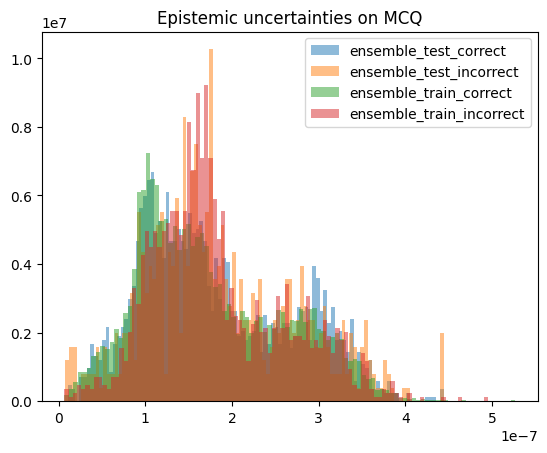

In [20]:
plt.figure()

for model_type, d in metrics.items():
    if model_type not in ["ensemble"]:
        continue
    for key in ["test", "train"]:
        for keyb in ["correct", "incorrect"]:
            responses = d[key][keyb]
        
            epistemic_uncertainty = []
            for response in responses:
                epistemic_uncertainty.append(response["epistemic_uncertainty"][0])

            plt.hist(epistemic_uncertainty, bins=100, density=True, label=f"{model_type}_{key}_{keyb}", alpha=0.5)

plt.legend()
plt.title("Epistemic uncertainties on MCQ")